In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from sasdata.dataloader.loader import Loader 
from sasmodels.core import load_model 
from sasmodels.direct_model import DirectModel
from sasmodels.data import Data1D 

import json

In [2]:
SI_FILE_LOC = './EXPTDATA_V2/sample_info_OMIECS.csv'
DATA_DIR = './EXPTDATA_V2/inco_bg_sub/'
MODEL = "cyl"

if MODEL == "sph":
    FITFILE_DIR = '/Users/pozzolabadmin/Documents/codebase/hyak_results/micelles_omiecs/results_simulfit_sph_fixvols/' 
    kernel = load_model("../models/spherical_micelle.py") 
elif MODEL == "cyl":
    FITFILE_DIR = '/Users/pozzolabadmin/Documents/codebase/hyak_results/micelles_omiecs/results_simulfit_cyl_fixvols/' 
    kernel = load_model("../models/cylindrical_micelle.py")     


In [3]:
def load_data_from_file(fname):
    SI = pd.read_csv(SI_FILE_LOC)
    flag = SI["Filename"]==fname
    metadata = SI[flag]
    loader = Loader()
    data = loader.load(DATA_DIR+'%s'%fname)[0]
    
    data.qmin = min(data.x)
    data.qmax = data.x[-metadata['Highq_trim']] 
    data.mask = (np.isnan(data.y) if data.y is not None
                         else np.zeros_like(data.x, dtype='bool'))
    
    return data, metadata

In [4]:
FIT_KEYS = [116,118,129,125,127,132,134,135,136,138,139,140,931,932,933,964,965,970,971] 
BLOCK_KEYS = [('DEG', '25b'), ('DEG', '50'), ('DEG', '75'), ('PEG', '25'), ('PEG', '50')]
FIT_BLOCK_KEY = ('DEG', '75') 
SIMUL_FILENAMES = [] 
SI = pd.read_csv(SI_FILE_LOC)
for key, values in SI.iterrows():
        if values['Sample'] in FIT_KEYS:
                if (values['EG_group']==FIT_BLOCK_KEY[0] and values['Flor_block']==FIT_BLOCK_KEY[1]):
                    fname = values['Filename']
                    SIMUL_FILENAMES.append(fname)
                    print(fname,values['EG_group'], values['Flor_block'])

D50F75_10dTHF75.sub DEG 75
D50F75_10dTol.sub DEG 75
D50F75_10dTHF50.sub DEG 75


In [5]:
datasets = []
metadatasets = []
fname = SIMUL_FILENAMES[0]
loaded_data, metadata = load_data_from_file(fname)
min_max_mask = (loaded_data.x >= loaded_data.qmin) & (loaded_data.x <= loaded_data.qmax)
data = Data1D(x =loaded_data.x[min_max_mask],
                y = loaded_data.y[min_max_mask],
                dx = loaded_data.dx[min_max_mask],
                dy = loaded_data.dy[min_max_mask]
                )

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F75_10dTHF75.sub'


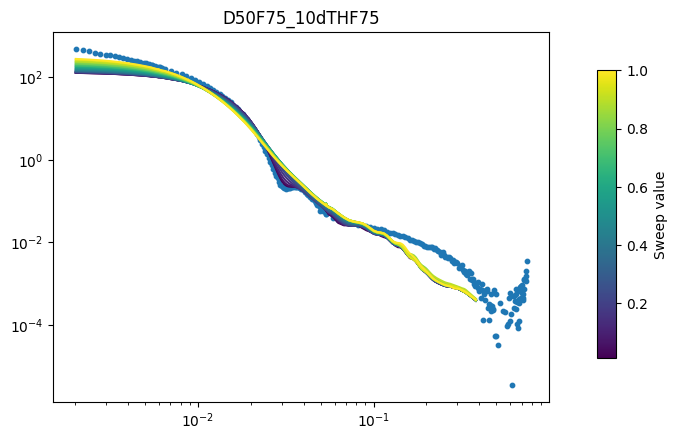

In [6]:
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import colormaps

cmap = colormaps['viridis']
par_key = "radius_core_pd"
par_min, par_max, n_pars = 0.01, 1.0, 20
norm = Normalize(vmin = par_min, vmax = par_max)
par_sweep = np.linspace(par_min, par_max, n_pars)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

json_name = fname.split('.')[0]
with open(FITFILE_DIR+'%s.json'%json_name) as f:
        params = json.load(f)
fig, ax = plt.subplots()
ax.scatter(loaded_data.x, loaded_data.y, s=10)
for ps in par_sweep:
        params.update({par_key: ps})
        model = DirectModel(data, kernel)
        Iq = model(**params) 
        ax.loglog(data.x, Iq, color=cmap(norm(ps)))
ax.set_title(json_name)
cax = plt.axes([0.975, 0.2, 0.03, 0.6])        
cbar = fig.colorbar(mappable, cax=cax)
cbar.ax.set_ylabel('Sweep value')
plt.show()